In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pathlib import Path

In [2]:
import matplotlib as mpl

# set font to 15
mpl.rcParams.update({'font.size': 15})

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [3]:
nerd_sqlite = '../../NERD_analysis/nerd.sqlite'

db_path = Path(nerd_sqlite).expanduser().resolve()
if not db_path.exists():
    raise FileNotFoundError(f"Database not found: {db_path}")

conn = sqlite3.connect(db_path)
conn.row_factory = sqlite3.Row

def read_sql(query: str, params: dict | None = None) -> pd.DataFrame:
    """Run a SQL query against the configured database and return a DataFrame."""
    return pd.read_sql_query(query, conn, params=params or {})

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


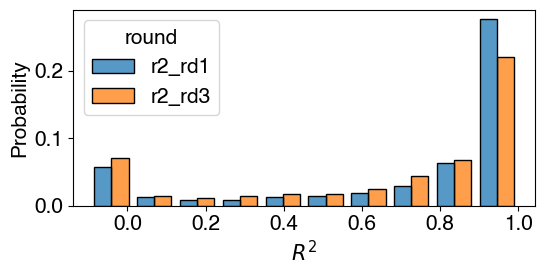

In [55]:
query_rd1 = """SELECT
    log_kobs,
    log_kdeg,
    r2,
    nt_base,
    nt_site,
    construct_name,
    temperature,
    rg_id,
    nt_id
FROM probe_tc_fits_view
WHERE fit_kind = 'round1_free';
"""

query_rd3 = """SELECT
    log_kobs,
    log_kdeg,
    r2,
    nt_base,
    nt_site,
    construct_name,
    temperature,
    rg_id,
    nt_id
FROM probe_tc_fits_view
WHERE fit_kind = 'round3_constrained';
"""

df_rd1 = read_sql(query_rd1)
df_rd3 = read_sql(query_rd3)


# merge on nt_id, rg_id
df_merged = pd.merge(df_rd1, df_rd3, on=['nt_id', 'rg_id'], suffixes=('_rd1', '_rd3'))


# melt to plot r2 dist (rd1 vs rd3)
df_melted = df_merged.melt(id_vars=['nt_id', 'rg_id'], value_vars=['r2_rd1', 'r2_rd3'], var_name='round', value_name='r2')
fig, ax = plt.subplots(figsize=(5.7, 3))
sns.histplot(data=df_melted, x='r2', hue='round', bins=10, multiple='dodge', shrink = 0.8, stat='probability', ax=ax)

ax.set_xlabel(r'$R^2$')
ax.set_ylabel('Probability')

plt.tight_layout()
plt.savefig('exports/r2_dist_rd1vrd3.pdf')
plt.show()

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


   temperature   log_kdeg
0         10.0 -10.639820
1         25.0  -8.213365
2         70.0  -3.731543


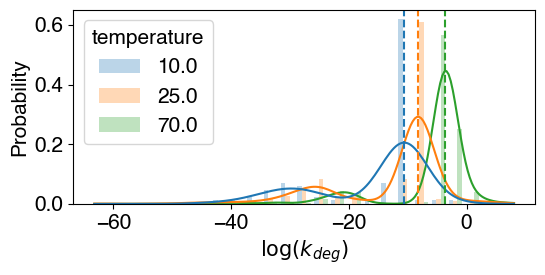

In [125]:
# filter temps to 10, 25, 70
df_rd1_filttemp = df_rd1[df_rd1['temperature'].isin([10, 25, 70])]
df_rd3_filttemp = df_rd3[df_rd3['temperature'].isin([10, 25, 70])]

# mean rd3 log_kdeg val for each temp
mean_log_kdeg_rd3 = df_rd3_filttemp.groupby('temperature')['log_kdeg'].mean().reset_index()
print(mean_log_kdeg_rd3)
# histplot df_rd1_filttemp of log_kdeg values hue by temperature
fig, ax = plt.subplots(figsize=(5.7, 3))
sns.histplot(data=df_rd1_filttemp, x='log_kdeg', bins=25, 
             multiple='dodge', hue = 'temperature', 
             palette = 'tab10', shrink = 0.8, 
             stat='probability', common_norm=False, 
             alpha=0.3,edgecolor=None,
             kde = True, ax=ax)
# vertical line at mean log_kdeg rd3 corresponding colors
for temp in mean_log_kdeg_rd3['temperature']:
    mean_val = mean_log_kdeg_rd3[mean_log_kdeg_rd3['temperature'] == temp]['log_kdeg'].values[0]
    ax.axvline(mean_val, color=sns.color_palette('tab10')[[10, 25, 70].index(temp)], linestyle='--', label=f'Global fit {temp}°C')

ax.set_xlabel(r'$\log(k_{deg})$')
ax.set_ylabel('Probability')
plt.tight_layout()

plt.savefig('exports/log_kdeg_dist_rd1.pdf')